# Classifying Genetic Mutation 



1. Packages

2. Downloading data

3. Preprocessing data

4. Primary data analysis

5. Data featurization

   1. Text Feature

      - TF-IDF

   2. Categorical Features
      - Response encoding

6. Secondary data analysis

   1. Visualizing high dimensional text features by t-SNE
   2. Visualizing Gene & Variation features by  t-SNE

7. ML model building

   1. Linear models
      1. SVM-RBF
      2. Logistic Regression (SGD)
   2. Ensemble models
      1. Random Forest
      2. XGBoost

8. Conclusion
   

<a name="cell-id1"></a>
# Packages

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

import re
from tqdm import tqdm
from datetime import datetime

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

palette = sns.color_palette("bright", 9)
plt.style.use('bmh')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
start=datetime.now()

# Downloading data

In [3]:
# Train Texts
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip' --output-document 'training_text.zip' && unzip training_text.zip

# Train Variants
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008828&Signature=daXpYlinA3JfM6dRDJO81AddsFlJ07GrZA%2FGaJHfHrhDEx69HUbj24gbH2ahVgwwjZtZ6FICDEefb8IoJXXceQEZEMy53%2Ff9QgMhI7PBgPFtQ3KgdzZ3%2BipqvntyPQlsa92qCBBwC91iG65TMB%2B4AjfhqydDUEtjNXiySnndKWwt04FZqTtHRf3LBvhwpf5mdi9U3Duk%2FI%2BnxDyoRwo1b2ffV3CJbNWDJSuXnN%2Fu8BmiCqndjVN6fi772VeXHn9R3vsgYEs4g%2FhTUFzSn%2FaW0%2FPrtKVhx%2Fd3QuqhQUh3%2BVNoI9qvFBB%2BlyyfyYUNBMsxrd0Oi6zkPmM8R2q6TeSTzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip' --output-document 'training_variants.zip' && unzip training_variants.zip

--2021-03-26 16:26:40--  https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63917183 (61M) [application/zip]
Saving to: ‘training_text.zip’

training_text.zip   10

In [4]:
! ls -I *.zip

training_variants.zip


<a name="cell-id3"></a>
# Data Preprocessing

In [5]:
variants_data = pd.read_csv('/content/training_variants', index_col=False)
variants_data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
texts_data = pd.read_csv('/content/training_text', 
                         sep="\|\|", 
                         engine="python", 
                         names=["ID","TEXT"], 
                         skiprows=1)

texts_data.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Merging variants and texts dataframes

In [7]:
data = pd.merge(texts_data, variants_data, on='ID', how='left')

data.head()

,ID,TEXT,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


## Highlevel overview

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   TEXT       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


1. There are 3321 entries in the dataframe.
2. Leaving ``Class`` column which is numerical representation of genetic mutation classes, rest are object datatype i.e. categorical and text.
3. The ``TEXT`` column have 05 entries lesser than the total 3321, we'd look at them later.

In [9]:
data['Class'].describe()

count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

## Preprocessing

### NaN values

In [10]:
data[data.isnull().any(axis=1)]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


- There are 05 rows in the data in the ``'TEXT'`` column which are NaN
- We'd  remove them, as these are text base and we cannot replace them with other values.

In [11]:
data.dropna(subset = ["TEXT"], inplace=True)

### Standard NLP preprocessing
- Removing stop words
- Removing puntuations

In [12]:
stop_words = set(stopwords.words('english'))

def text_processing(text):
  """Processing the sentence (single entry)."""

  text = re.sub('\s+',' ', text)
  text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
  text = text.lower()

  tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

  return ' '.join(tokens)

In [13]:
for index, text in tqdm(data.TEXT.iteritems()):
  data["TEXT"][index] = text_processing(text)

3316it [02:35, 21.34it/s]


In [14]:
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

In [15]:
data.head(2)

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating_Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2


In [16]:
len((data['TEXT'].max()).split(' '))

2749

In [17]:
# Copying newly created dataframe into csv
# data.to_csv('CGM-processed.csv', index=False)

In [18]:
# Copying to google drive
# !cp -r /content/CGM-processed.csv /content/drive/MyDrive/Data/CGV-Data

<a name="cell-id4"></a>
# Primary data analysis

In [19]:
# TBW

<a name="cell-id5"></a>
# Data featurization

In [20]:
from keras.utils.np_utils import to_categorical

In [21]:
y = np.array(data['Class'].values)

In [22]:
X = data[data.columns[1:4]]

In [23]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y)

In [24]:
x_train.shape

(2321, 3)

In [25]:
x_test.shape

(995, 3)

In [26]:
x_test.head()

,TEXT,Gene,Variation
1688,early signal relay steps upon ligand binding r...,FLT3,Y599F
2319,abstract jak2 v617f mutation present 95 polycy...,JAK2,K539L
2444,germline mutations breast cancer 1 brca1 gene ...,BRCA1,K38N
1333,mismatch repair factors prominent role surveyi...,MLH1,L749P
152,abstract glioblastomas egfr amplification repr...,EGFR,EGFRvII


## Categorical

In [36]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Gene'])

ohe_tr_gene = one_hot.transform(x_train['Gene'])
ohe_ts_gene = one_hot.transform(x_test['Gene'])

In [38]:
print(f"OneHotEncoded Gene: {ohe_tr_gene.shape}")
print(f"OneHotEncoded Gene: {ohe_ts_gene.shape}")

OneHotEncoded Gene: (2321, 239)
OneHotEncoded Gene: (995, 239)


In [39]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Variation'])

ohe_tr_var = one_hot.transform(x_train['Variation'])
ohe_ts_var = one_hot.transform(x_test['Variation'])

In [40]:
print(f"OneHotEncoded Variation: {ohe_tr_var.shape}")
print(f"OneHotEncoded Variation: {ohe_ts_var.shape}")

OneHotEncoded Variation: (2321, 2147)
OneHotEncoded Variation: (995, 2147)


## Text

### TF-IDF 

In [41]:
vec_start = datetime.now()

tfidf = TfidfVectorizer(ngram_range=(2, 4), 
                        sublinear_tf=True, 
                        max_features=3000).fit(x_train['TEXT'])

tfidf_tr_text = tfidf.transform(x_train['TEXT'])
tfidf_ts_text = tfidf.transform(x_test['TEXT'])

vec_end = datetime.now()
print(f"Took: {vec_end-vec_start}")

Took: 0:03:24.676914


In [42]:
tfidf_ts_text.shape

(995, 3000)

In [33]:
tfidf_tr_text.shape

(2321, 3000)

In [34]:
%xdel tfidf

## Concatenation

In [47]:
train = np.hstack((tfidf_tr_text.toarray(), 
                   ohe_tr_var.toarray(), 
                   ohe_tr_gene.toarray()))

test = np.hstack((tfidf_ts_text.toarray(), 
                  ohe_ts_var.toarray(), 
                  ohe_ts_gene.toarray()))

In [48]:
print(f"Train X: {train.shape}\ty: {y_train.shape}")
print(f"Test X: {test.shape}\ty: {y_test.shape}")

Train X: (2321, 5386)	y: (2321,)
Test X: (995, 5386)	y: (995,)


<a name="cell-id6"></a>
# Secondary data analysis

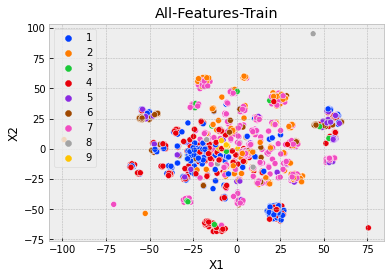

In [49]:
X_embedded = TSNE(n_components=2).fit_transform(train) 

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], 
                hue=y_train, legend='full', palette=palette)
plt.title('All-Features-Train')
plt.xlabel('X1')
plt.ylabel('X2')
plt.savefig("All-Features-Train.png", dpi=256)

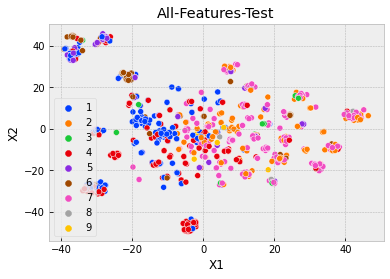

In [50]:
X_embedded = TSNE(n_components=2).fit_transform(test) 

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], 
                hue=y_test, legend='full', palette=palette)
plt.title('All-Features-Test')
plt.xlabel('X1')
plt.ylabel('X2')
plt.savefig("All-Features-Test.png", dpi=256)

# Machine learning model

<a name="cell-id8"></a>
# Conclusion

In [51]:
end=datetime.now()

print(f"Time took for whole Notebook - {end-start}")

Time took for whole Notebook - 0:18:40.167119
